In [1]:
import pandas as pd
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
import numpy as np
import os
import time
import warnings
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

sec = 1

# Set secx = 60 for 1-sec timestep dataset
def load_data(filename, secx = 1):
    sec = secx
    df = read_csv(filename, index_col=0)
    # Set columns type
    df['Chg_USB'] = df['Chg_USB'].astype('bool_')
    df['Chg_Wireless'] = df['Chg_Wireless'].astype('bool_')
    df['Chg_AC'] = df['Chg_AC'].astype('bool_')
    df['Is_Charging'] = df['Is_Charging'].astype('bool_')
    df['WIFI_Status'] = df['WIFI_Status'].astype('bool_')
    df['Percentage'] = df['Percentage'].astype('float32')
    df['Bluetooth_Status'] = df['Bluetooth_Status'].astype('bool_')
    df['Cellular_Status'] = df['Cellular_Status'].astype('bool_')
    df['Screen_Status'] = df['Screen_Status'].astype('bool_')

    # Shifting with 30 minutes window size
    window_size = 30*sec
    df['WIFI_Status_S'] = df['WIFI_Status'].copy()
    df['WIFI_Status_S'] = df['WIFI_Status_S'].shift(-window_size)
    # Drop null rows at the end
    df.dropna(inplace=True)

    # Trim to the specific time range (3 months)
    df = df[:60*24*90*sec]
    x = df.loc[:, ['Minute', 'Date', 'DayOfWeek', 'Is_Charging', 'Chg_USB', 'Chg_Wireless', 'Chg_AC', 'WIFI_Status', 'Percentage', 'Bluetooth_Status', 'Cellular_Status', 'Screen_Status']].values.copy()
    y = df.loc[:, ['WIFI_Status_S']].values.copy()

    # Normalize
    x[:,0] = x[:,0] / 1440 # Minute
    x[:,1] = x[:,1] / 31   # Date
    x[:,2] = x[:,2] / 7    # DayOfWeek

    # 72 days train data, 18 days test data
    rows = 60*24*72*sec
    train_x = x[:int(rows), :]
    test_x = x[int(rows):, :]
    train_y = y[:int(rows), :]
    test_y = y[int(rows):, :]

    # Reshape to put into the model, from (n_rows, n_columns) to (n_rows, n_columns, 1)
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

    print('Train x: ', train_x.shape)
    print('Train y: ', train_y.shape)
    print('Test x: ', test_x.shape)
    print('Test y: ', test_y.shape)
    
    return df, train_x, test_x, train_y, test_y
    

def build_model(layers):
    model = Sequential()

    model.add(LSTM(return_sequences=True, input_shape=(12, layers[0]), units=layers[1]))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="adam")
    print("> Compilation Time : ", time.time() - start)
    model.summary()
    return model


def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted


def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white', figsize=(15,5))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()
    
def confusion_matrix(predictions, test):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    print(predictions.shape[0])

    for i in range(predictions.shape[0]):
        if predictions[i] == 1:
            if test[i] == 1:
                tp = tp + 1
            else:
                fp = fp + 1
        elif predictions[i] == 0:
            if test[i] == 1:
                fn = fn + 1
            else:
                tn = tn + 1
    print("True positive: " + str(tp) + "(" + str(tp / predictions.shape[0] * 100) + "%)" + "\nTrue negative: " + str(tn) + "(" + str(tn / predictions.shape[0] * 100) + "%)"  + "\nFalse positive: " + str(fp) + "(" + str(fp / predictions.shape[0] * 100) + "%)"  + "\nFalse negative: " + str(fn) + "(" + str(fn / predictions.shape[0] * 100) + "%)")
    print("Accuracy = " + str((tp + tn) / (tp + tn + fp + fn) * 100) + "%")

Using TensorFlow backend.


In [2]:
# Load data from CSV file
df, train_x, test_x, train_y, test_y = load_data('./Dataset/resourcemonitordata1minbool.csv', 1)

Train x:  (103680, 12, 1)
Train y:  (103680, 1)
Test x:  (25920, 12, 1)
Test y:  (25920, 1)


In [ ]:
# Finding the best number of epochs
model = build_model([1, 50, 100, 1])
historyep = model.fit(train_x, train_y, batch_size=30, epochs=30, validation_split=0.2)

plt.plot(historyep.history['loss'])
plt.plot(historyep.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper left')
plt.show()

> Compilation Time :  0.027126073837280273
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 12, 50)            10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_____________________________

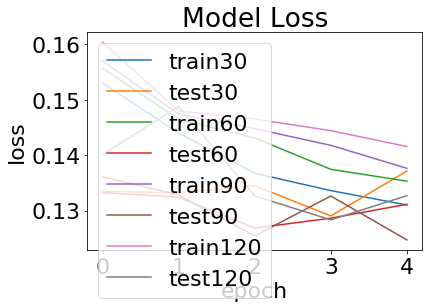

In [4]:
# Finding the best batch size
model30 = build_model([1, 50, 100, 1])
model60 = build_model([1, 50, 100, 1])
model90 = build_model([1, 50, 100, 1])
model120 = build_model([1, 50, 100, 1])
history30 = model30.fit(train_x, train_y, batch_size=30, epochs=5, validation_split=0.2)
history60 = model60.fit(train_x, train_y, batch_size=60, epochs=5, validation_split=0.2)
history90 = model90.fit(train_x, train_y, batch_size=90, epochs=5, validation_split=0.2)
history120 = model120.fit(train_x, train_y, batch_size=120, epochs=5, validation_split=0.2)

plt.plot(history30.history['loss'])
plt.plot(history30.history['val_loss'])
plt.plot(history60.history['loss'])
plt.plot(history60.history['val_loss'])
plt.plot(history90.history['loss'])
plt.plot(history90.history['val_loss'])
plt.plot(history120.history['loss'])
plt.plot(history120.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train30', 'test30','train60', 'test60', 'train90', 'test90', 'train120', 'test120'], loc='upper left')
plt.show()

25920
True positive: 16988(65.54012345679013%)
True negative: 4059(15.659722222222221%)
False positive: 3236(12.484567901234568%)
False negative: 1637(6.315586419753086%)
Accuracy = 81.19984567901236%


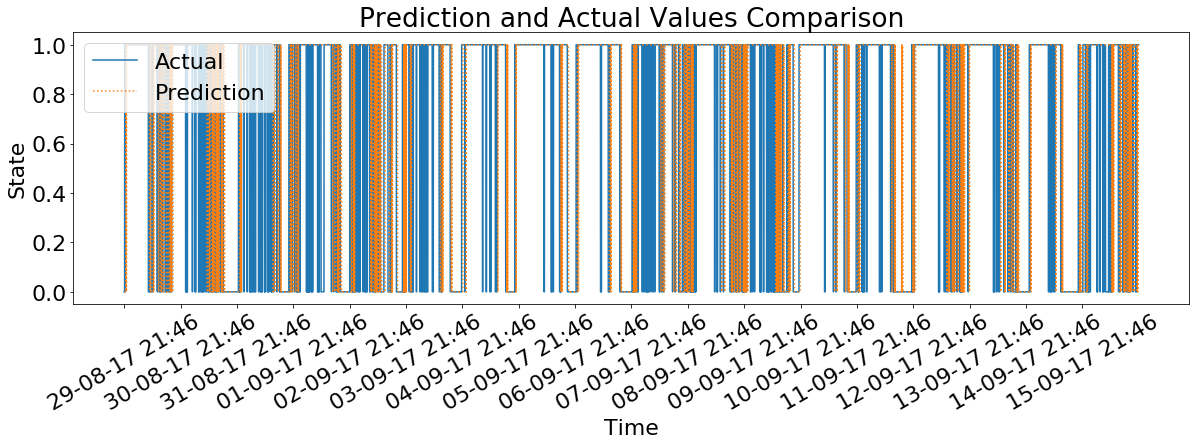

In [5]:
# Make predictions on the test set
predictions90 = predict_point_by_point(model90, test_x)
predictions90 = predictions90.round()

from operator import itemgetter

plt.figure(figsize=(20,5))
plt.rcParams.update({'font.size': 22})
plt.plot(test_y)
plt.plot(predictions90, ls=':')
plt.title('Prediction and Actual Values Comparison')
ind = np.arange(0, 25919, step=1440)
dates = itemgetter(*ind)(df.index.values[60*24*72:]) # Get dates from index to use as x-axis values
plt.xticks(np.arange(0, 25919, step=1440), dates, rotation=30)
plt.ylabel('State')
plt.xlabel('Time')
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.show

confusion_matrix(predictions90, test_y)


In [6]:
model.save('./Model/TrainedModel.h5')

%run keras_to_tensorflow.py -input_model_file ./Model/TrainedModel.h5 -output_model_file ./Model/FreezeGraph.pb

usage: keras_to_tensorflow.py [-h] [-input_fld INPUT_FLD]
                              [-output_fld OUTPUT_FLD]
                              [-input_model_file INPUT_MODEL_FILE]
                              [-output_model_file OUTPUT_MODEL_FILE]
                              [-output_graphdef_file OUTPUT_GRAPHDEF_FILE]
                              [-num_outputs NUM_OUTPUTS]
                              [-graph_def GRAPH_DEF]
                              [-output_node_prefix OUTPUT_NODE_PREFIX]
                              [-quantize QUANTIZE]
                              [-theano_backend THEANO_BACKEND] [-f F]

set input arguments

optional arguments:
  -h, --help            show this help message and exit
  -input_fld INPUT_FLD
  -output_fld OUTPUT_FLD
  -input_model_file INPUT_MODEL_FILE
  -output_model_file OUTPUT_MODEL_FILE
  -output_graphdef_file OUTPUT_GRAPHDEF_FILE
  -num_outputs NUM_OUTPUTS
  -graph_def GRAPH_DEF
  -output_node_prefix OUTPUT_NODE_PREFIX
  -quantize QUAN